In [1]:
import pandas as pd
from calitp_data_analysis.tables import tbls
from siuba import _, collect, count, filter, show_query
from update_vars import GCS_FILE_PATH
import altair as alt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Additional Transit Performance Metrics #899

Use the newer recommendations which include performance metrics and ridership experience as outlined in the [UCLA Options for the Future of State Funding for Transit Operations in California](https://escholarship.org/uc/item/2zb6z5rm).  Should try and run/describe all outlined.


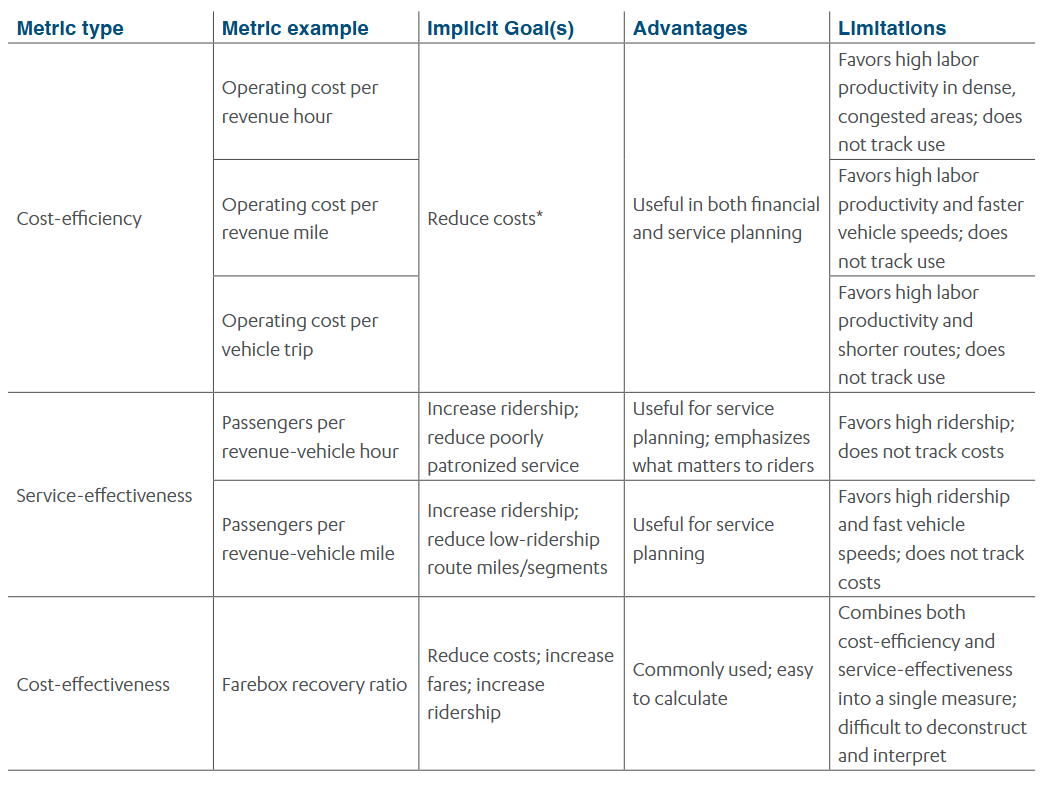

## Data Sources

NTD Products
- [2023 Annual Database Operating Expenses](https://www.transit.dot.gov/ntd/data-product/2023-annual-database-operating-expenses)
    - data url: "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Operating%20Expenses.xlsx"
- [2022 Annual Database Operating Expenses](https://www.transit.dot.gov/ntd/data-product/2022-annual-database-operating-expenses)
    - data url: "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-04/2022%20Operating%20Expenses.xlsx"

Warehose Tables
- <s>`dim_monthly_ridership_with_adjustments `</s>, but is only for Monthly reporters
- `dim_annual_service_agencies`, has all type of reporters, VRM, VRH, UPT

## Metrics to calculate

Cost-efficiency metrics
- Operating cost per VRH
- Operating cost per VRM
- Operating cost per trip(?)

Service-effectiveness metrics
- Passengers (upt?) per VRH
- Passengers per VRM

---

## Use `dim_annual_service_agencies` to get vrm, upt, vrh, for CA reporters.
- also contains  `2023 operating cost`

In [2]:
# read in dim_annual_service_agencies, filter for reporters in CA for 2023

annnual_service_agencies = (
    tbls.mart_ntd.dim_annual_service_agencies() 
    >> filter(_.state == "CA",
              _.report_year == 2023
             )
    >> collect()
)
annnual_service_agencies.info() # 209 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   key                                             209 non-null    object 
 1   report_year                                     209 non-null    int64  
 2   ntd_id                                          209 non-null    object 
 3   agency                                          209 non-null    object 
 4   reporter_type                                   209 non-null    object 
 5   organization_type                               209 non-null    object 
 6   city                                            208 non-null    object 
 7   state                                           209 non-null    object 
 8   agency_voms                                     209 non-null    float64
 9   primary_uza_code                           

### get `NTD IDs` for CA reporters
- will be used to filter the operating expense report

In [3]:
ca_ntd_ids = annnual_service_agencies["ntd_id"].unique() # unique ntd ID to filter by

display(
    type(ca_ntd_ids),
    len(ca_ntd_ids),
)

numpy.ndarray

209

## get `Operating expense` from NTD data report - `2023 Operating Expense`

In [4]:
# Read in 2023 NTD operating exp data
ntd_2023_opex = "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Operating%20Expenses.xlsx"

col_dict={'NTD ID':str}

opex_2023 = pd.read_excel(
    ntd_2023_opex, 
    dtype = (col_dict)
)
opex_2023.head() # what is the `total` rows in `operating expense type? is it the the sum of the other categories?
# do i sum `total` with the other categories?

,State NTD ID,NTD ID,Agency Name,Reporter Type,Reporting Module,Mode,TOS,Operating Expense Type,Operators' Salaries and Wages,Operators' Paid Absences,Other Salaries and Wages,Other Paid Absences,Fringe Benefits,Service Costs,Fuel and Lubricants,Tires and Tubes,Other Materials and Supplies,Utilities,Casualty and Liability Costs,Taxes,PT Funds In Report,PT Funds Reported Separately,Miscellaneous Expenses,Reduced Reporting Waiver - Total OE,Total Operating Expenses,Total Operating Expenses (No Funds Reported Separately),ADA Related Expenses
0,NaN,1,King County,Full Reporter,Urban,CB,PT,Facility Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1947331.0,0.0,NaN,1947331,0,NaN
1,NaN,1,King County,Full Reporter,Urban,CB,PT,General Administration,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,9157562.0,0.0,NaN,9157562,0,NaN
2,NaN,1,King County,Full Reporter,Urban,CB,PT,Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57079186.0,0.0,0.0,57079186,0,NaN
3,NaN,1,King County,Full Reporter,Urban,CB,PT,Vehicle Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,12729609.0,0.0,NaN,12729609,0,NaN
4,NaN,1,King County,Full Reporter,Urban,CB,PT,Vehicle Operations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,33244684.0,0.0,NaN,33244684,0,NaN


- Confirmed with the [data.transportation.gov interface](https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Operating-Expenses-by-Ty/j5uj-anzx/explore/query/SELECT%0A%20%20%60agency%60%2C%0A%20%20%60city%60%2C%0A%20%20%60state%60%2C%0A%20%20%60ntd_id%60%2C%0A%20%20%60organization_type%60%2C%0A%20%20%60reporter_type%60%2C%0A%20%20%60report_year%60%2C%0A%20%20%60uace_code%60%2C%0A%20%20%60uza_name%60%2C%0A%20%20%60primary_uza_population%60%2C%0A%20%20%60agency_voms%60%2C%0A%20%20%60mode%60%2C%0A%20%20%60mode_name%60%2C%0A%20%20%60type_of_service%60%2C%0A%20%20%60mode_voms%60%2C%0A%20%20%60operators_wages%60%2C%0A%20%20%60operators_wages_questionable%60%2C%0A%20%20%60other_salaries_wages%60%2C%0A%20%20%60other_salaries_wages_1%60%2C%0A%20%20%60operator_paid_absences%60%2C%0A%20%20%60operator_paid_absences_1%60%2C%0A%20%20%60other_paid_absences%60%2C%0A%20%20%60other_paid_absences_1%60%2C%0A%20%20%60fringe_benefits%60%2C%0A%20%20%60fringe_benefits_questionable%60%2C%0A%20%20%60services%60%2C%0A%20%20%60services_questionable%60%2C%0A%20%20%60fuel_and_lube%60%2C%0A%20%20%60fuel_and_lube_questionable%60%2C%0A%20%20%60tires%60%2C%0A%20%20%60tires_questionable%60%2C%0A%20%20%60other_materials_supplies%60%2C%0A%20%20%60other_materials_supplies_1%60%2C%0A%20%20%60utilities%60%2C%0A%20%20%60utilities_questionable%60%2C%0A%20%20%60casualty_and_liability%60%2C%0A%20%20%60casualty_and_liability_1%60%2C%0A%20%20%60taxes%60%2C%0A%20%20%60taxes_questionable%60%2C%0A%20%20%60purchased_transportation%60%2C%0A%20%20%60purchased_transportation_1%60%2C%0A%20%20%60miscellaneous%60%2C%0A%20%20%60miscellaneous_questionable%60%2C%0A%20%20%60reduced_reporter_expenses%60%2C%0A%20%20%60reduced_reporter_expenses_1%60%2C%0A%20%20%60total%60%2C%0A%20%20%60total_questionable%60%2C%0A%20%20%60separate_report_amount%60%2C%0A%20%20%60separate_report_amount_1%60%0AWHERE%0A%20%20caseless_one_of%28%60report_year%60%2C%20%222023%22%29%0A%20%20AND%20%28caseless_one_of%28%60state%60%2C%20%22CA%22%29%0A%20%20%20%20%20%20%20%20%20AND%20caseless_one_of%28%0A%20%20%20%20%20%20%20%20%20%20%20%60agency%60%2C%0A%20%20%20%20%20%20%20%20%20%20%20%22Sacramento%20Regional%20Transit%20District%2C%20dba%3A%20Sacramento%20RT%22%0A%20%20%20%20%20%20%20%20%20%29%29/page/filter) to use `total operating expense type = "Total" `

In [5]:
keep_cols = [
    "NTD ID",
    "Agency Name",
    "Reporter Type",
    "Operating Expense Type", 
    "Total Operating Expenses",
    "Total Operating Expenses (No Funds Reported Separately)" 
]

ca_opex_2023 = opex_2023[
    opex_2023["NTD ID"].isin(ca_ntd_ids) # filter for CA reporters
][keep_cols] #1250 rows

ca_opex_2023 = ca_opex_2023[ca_opex_2023["Operating Expense Type"] == "Total"] #426 rows

ca_opex_agg = ca_opex_2023.groupby(["NTD ID","Agency Name"]).agg({ #agg by ntd id and agency
    "Total Operating Expenses":"sum"
}).reset_index() 

display(
    ca_opex_2023["NTD ID"].nunique(),#209, matches unique ntd ids list
    ca_opex_2023.info(), 
    ca_opex_agg["Agency Name"].value_counts().head(),# LA County has multiple NTD IDs?
    ca_opex_agg.head(),
)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 7590 to 9059
Data columns (total 6 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   NTD ID                                                   426 non-null    object
 1   Agency Name                                              426 non-null    object
 2   Reporter Type                                            426 non-null    object
 3   Operating Expense Type                                   426 non-null    object
 4   Total Operating Expenses                                 426 non-null    int64 
 5   Total Operating Expenses (No Funds Reported Separately)  426 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 23.3+ KB


209

None

Los Angeles County                               9
Los Angeles County                               2
San Francisco Bay Area Rapid Transit District    1
City of Rosemead                                 1
City of South Gate                               1
Name: Agency Name, dtype: int64

,NTD ID,Agency Name,Total Operating Expenses
0,90003,San Francisco Bay Area Rapid Transit District,796259977
1,90004,Golden Empire Transit District,36554386
2,90006,Santa Cruz Metropolitan Transit District,48569321
3,90008,City of Santa Monica,80777272
4,90009,San Mateo County Transit District,192548133


## merge `dim_annual_service_agencies` to ca opex report to get operating cost against upt, vrm,vrh.

In [6]:
print(len(annnual_service_agencies))
keep_cols_2 = [
    "key",
    "report_year",
    "ntd_id",
    "agency",
    "reporter_type",
    "organization_type",
    "actual_vehicles_passenger_car_revenue_hours",
    "actual_vehicles_passenger_car_revenue_miles",
    "unlinked_passenger_trips_upt",
    "Total Operating Expenses"
]


ca_service_agency_opex = annnual_service_agencies.merge(
    ca_opex_agg,
    how="inner", 
    left_on="ntd_id", 
    right_on="NTD ID"
)[keep_cols_2]

print(ca_service_agency_opex.info())

209
<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   key                                          209 non-null    object 
 1   report_year                                  209 non-null    int64  
 2   ntd_id                                       209 non-null    object 
 3   agency                                       209 non-null    object 
 4   reporter_type                                209 non-null    object 
 5   organization_type                            209 non-null    object 
 6   actual_vehicles_passenger_car_revenue_hours  209 non-null    float64
 7   actual_vehicles_passenger_car_revenue_miles  209 non-null    float64
 8   unlinked_passenger_trips_upt                 209 non-null    float64
 9   Total Operating Expenses                     209 non-null    int64  
dty

## Test of using data from `mart_ntd_annual_reporting.fct_metrics`

In [7]:
keep_cols_metrics =[
    "ntd_id",
    "agency",
    "organization_type",
    "reporter_type",
    "city",
    "uza_name",
    "agency_voms",
    "mode",
    "type_of_service",
    "report_year",
    "total_operating_expenses",
    "unlinked_passenger_trips",
    "vehicle_revenue_hours",
    "vehicle_revenue_miles",
]

fct_metrics = (
    tbls.mart_ntd_annual_reporting.fct_metrics() 
    >> filter(_.state == "CA",
              #_.report_year == 2023
             )
    >> collect()
)[keep_cols_metrics]

fct_metrics.info() # 852 rows

# grain is agency by mode,tos and report_year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ntd_id                    852 non-null    object 
 1   agency                    852 non-null    object 
 2   organization_type         852 non-null    object 
 3   reporter_type             852 non-null    object 
 4   city                      847 non-null    object 
 5   uza_name                  692 non-null    object 
 6   agency_voms               852 non-null    float64
 7   mode                      852 non-null    object 
 8   type_of_service           852 non-null    object 
 9   report_year               852 non-null    int64  
 10  total_operating_expenses  852 non-null    float64
 11  unlinked_passenger_trips  852 non-null    float64
 12  vehicle_revenue_hours     852 non-null    float64
 13  vehicle_revenue_miles     852 non-null    float64
dtypes: float64

In [8]:
# need to agg by agency, ntd id
agg_metrics = fct_metrics.groupby(
    [
        "ntd_id", 
        "agency", 
        "report_year",
        "organization_type",
        "reporter_type",
        "uza_name",
    ]
).agg(
    total_opex = ("total_operating_expenses","sum"),
    total_upt = ("unlinked_passenger_trips","sum"),
    total_vrh = ("vehicle_revenue_hours","sum"),
    total_vrm = ("vehicle_revenue_miles","sum")
).reset_index()

display(
    agg_metrics.info(),
    agg_metrics.head()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             328 non-null    object 
 1   agency             328 non-null    object 
 2   report_year        328 non-null    int64  
 3   organization_type  328 non-null    object 
 4   reporter_type      328 non-null    object 
 5   uza_name           328 non-null    object 
 6   total_opex         328 non-null    float64
 7   total_upt          328 non-null    float64
 8   total_vrh          328 non-null    float64
 9   total_vrm          328 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 25.8+ KB


None

,ntd_id,agency,report_year,organization_type,reporter_type,uza_name,total_opex,total_upt,total_vrh,total_vrm
0,90003,San Francisco Bay Area Rapid Transit District,2022,Independent Public Agency or Authority of Tran...,Full Reporter,"San Francisco--Oakland, CA",685513460.0,38224072.0,2486029.0,78554914.0
1,90003,"San Francisco Bay Area Rapid Transit District,...",2023,Independent Public Agency or Authority of Tran...,Full Reporter,"San Francisco--Oakland, CA",782182726.0,50764402.0,2724074.0,85233749.0
2,90004,Golden Empire Transit District,2022,Independent Public Agency or Authority of Tran...,Full Reporter,"Bakersfield, CA",34015271.0,3201046.0,292325.0,3758507.0
3,90004,Golden Empire Transit District,2023,Independent Public Agency or Authority of Tran...,Full Reporter,"Bakersfield, CA",36554386.0,3293593.0,289338.0,3924016.0
4,90006,Santa Cruz Metropolitan Transit District,2022,Independent Public Agency or Authority of Tran...,Full Reporter,"Santa Cruz, CA",50108301.0,2837891.0,211715.0,2952329.0


## calculate z-scores to find outliers?

In [9]:
from scipy.stats import zscore

### get zscores from quant columns

In [10]:
z_score = agg_metrics[[
    "total_opex",
    "total_upt",
    "total_vrh",
    "total_vrm"
]].apply(zscore)

z_score.describe()

,total_opex,total_upt,total_vrh,total_vrm
count,3.280000e+02,328.000000,3.280000e+02,328.000000
mean,-2.166289e-17,0.000000,2.166289e-17,0.000000
std,1.001528e+00,1.001528,1.001528e+00,1.001528
min,-2.653099e-01,-0.197716,-3.118913e-01,-0.318068
25%,-2.604015e-01,-0.196149,-2.986990e-01,-0.310342
50%,-2.449899e-01,-0.188899,-2.718320e-01,-0.280306
75%,-1.444463e-01,-0.142180,-1.350203e-01,-0.142633
max,1.119466e+01,11.488903,1.039509e+01,9.245511


### remove outliers

In [11]:
threshold = 3
agg_metrics_no_outliers = agg_metrics[(z_score.abs() < threshold).all(axis=1)]


,ntd_id,agency,report_year,organization_type,reporter_type,uza_name,total_opex,total_upt,total_vrh,total_vrm
2,90004,Golden Empire Transit District,2022,Independent Public Agency or Authority of Tran...,Full Reporter,"Bakersfield, CA",34015271.0,3201046.0,292325.0,3758507.0
3,90004,Golden Empire Transit District,2023,Independent Public Agency or Authority of Tran...,Full Reporter,"Bakersfield, CA",36554386.0,3293593.0,289338.0,3924016.0
4,90006,Santa Cruz Metropolitan Transit District,2022,Independent Public Agency or Authority of Tran...,Full Reporter,"Santa Cruz, CA",50108301.0,2837891.0,211715.0,2952329.0
5,90006,Santa Cruz Metropolitan Transit District,2023,Independent Public Agency or Authority of Tran...,Full Reporter,"Santa Cruz, CA",48569321.0,3350026.0,214748.0,2975126.0
6,90008,"City of Santa Monica, dba: Big Blue Bus",2022,"City, County or Local Government Unit or Depar...",Full Reporter,"Los Angeles--Long Beach--Anaheim, CA",74682352.0,6333923.0,418023.0,3969681.0


In [12]:
display(
    "initial data",
    agg_metrics.describe(), #328 rows 
    "outliers removed",
    agg_metrics_no_outliers.describe() #320 rows
)
# can see that the min/max values of each col were adjusted.

'initial data'

,report_year,total_opex,total_upt,total_vrh,total_vrm
count,328.000000,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02
mean,2022.503049,5.087384e+07,4.674597e+06,2.394732e+05,3.641606e+06
std,0.500755,1.919692e+08,2.367875e+07,7.689089e+05,1.146368e+07
min,2022.000000,2.020000e+04,6.000000e+01,2.300000e+01,9.360000e+02
25%,2022.000000,9.610335e+05,3.710825e+04,1.015125e+04,8.937725e+04
50%,2023.000000,3.915064e+06,2.085255e+05,3.077800e+04,4.331665e+05
75%,2023.000000,2.318690e+07,1.313079e+06,1.358132e+05,2.008999e+06
max,2023.000000,2.196624e+09,2.763024e+08,8.220160e+06,1.094675e+08


'outliers removed'

,report_year,total_opex,total_upt,total_vrh,total_vrm
count,320.000000,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02
mean,2022.503125,2.708031e+07,1.704175e+06,1.436209e+05,2.203676e+06
std,0.500773,6.848450e+07,4.485319e+06,3.198820e+05,4.589184e+06
min,2022.000000,2.020000e+04,6.000000e+01,2.300000e+01,9.360000e+02
25%,2022.000000,9.381112e+05,3.667050e+04,9.687750e+03,8.537925e+04
50%,2023.000000,3.784568e+06,1.879675e+05,2.935850e+04,4.194670e+05
75%,2023.000000,1.747781e+07,1.114006e+06,1.213920e+05,1.829048e+06
max,2023.000000,5.324067e+08,3.519006e+07,2.076903e+06,3.196940e+07


## calculate new performance metrics on `mart_ntd_annual_reporting.fct_metrics`

In [13]:
calc_dict = {
    "opex_per_vrh":("total_opex", "total_vrh"),
    "opex_per_vrm":("total_opex","total_vrm"),
    "upt_per_vrh":("total_upt","total_vrh"),
    "upt_per_vrm":("total_upt","total_vrm"),
    "opex_per_upt":("total_opex","total_upt")
}

for new_col, (num,dem) in calc_dict.items():
    agg_metrics_no_outliers[new_col] = agg_metrics_no_outliers[num]/agg_metrics_no_outliers[dem]
    
agg_metrics_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 2 to 327
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             320 non-null    object 
 1   agency             320 non-null    object 
 2   report_year        320 non-null    int64  
 3   organization_type  320 non-null    object 
 4   reporter_type      320 non-null    object 
 5   uza_name           320 non-null    object 
 6   total_opex         320 non-null    float64
 7   total_upt          320 non-null    float64
 8   total_vrh          320 non-null    float64
 9   total_vrm          320 non-null    float64
 10  opex_per_vrh       320 non-null    float64
 11  opex_per_vrm       320 non-null    float64
 12  upt_per_vrh        320 non-null    float64
 13  upt_per_vrm        320 non-null    float64
 14  opex_per_upt       320 non-null    float64
dtypes: float64(9), int64(1), object(5)
memory usage: 40.0+ KB


/tmp/ipykernel_290/1018247822.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_metrics_no_outliers[new_col] = agg_metrics_no_outliers[num]/agg_metrics_no_outliers[dem]
/tmp/ipykernel_290/1018247822.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_metrics_no_outliers[new_col] = agg_metrics_no_outliers[num]/agg_metrics_no_outliers[dem]
/tmp/ipykernel_290/1018247822.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

## summary stats 

In [14]:
agg_metrics_no_outliers.describe()

,report_year,total_opex,total_upt,total_vrh,total_vrm,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
count,320.000000,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,320.000000,320.000000,320.000000,320.000000,320.000000
mean,2022.503125,2.708031e+07,1.704175e+06,1.436209e+05,2.203676e+06,178.870835,12.816519,8.446547,0.690232,33.211773
std,0.500773,6.848450e+07,4.485319e+06,3.198820e+05,4.589184e+06,229.549837,10.279010,8.673213,0.832987,40.086081
min,2022.000000,2.020000e+04,6.000000e+01,2.300000e+01,9.360000e+02,24.876196,0.532521,1.001743,0.064103,1.880813
25%,2022.000000,9.381112e+05,3.667050e+04,9.687750e+03,8.537925e+04,100.205907,8.082051,3.393262,0.264650,12.593110
50%,2023.000000,3.784568e+06,1.879675e+05,2.935850e+04,4.194670e+05,134.090669,10.619899,5.961613,0.460403,20.805783
75%,2023.000000,1.747781e+07,1.114006e+06,1.213920e+05,1.829048e+06,168.629382,14.531763,11.107667,0.807923,42.608547
max,2023.000000,5.324067e+08,3.519006e+07,2.076903e+06,3.196940e+07,2224.457643,107.340115,81.441915,7.224591,480.733333


In [62]:
def make_bar(data, x_ax, y_ax, color=None, column=None, x_offset=None, row=None):
    # Base chart
    chart = alt.Chart(data).mark_bar().encode(
        x=x_ax,
        y=y_ax,
        tooltip=[x_ax, y_ax, "agency"]
    )
    
    # Add color encoding if provided
    if color:
        chart = chart.encode(color=color)
    
    # Add column facet if provided
    if column:
        chart = chart.encode(column=column)
    
    if row:
        chart = chart.encode(row=row)
    
    if x_offset: # only works in horizontal bar charts
        chart = chart.encode(xOffset= x_offset)
        
    # Add title and interactivity
    chart = chart.properties(title=f"{x_ax} vs. {y_ax}").interactive()
    
    return chart


In [24]:
def make_scatter(
    data,
    x_ax,
    y_ax,
    color = None,
    column = None
):
    chart = alt.Chart(data).mark_point().encode(
    x = x_ax,
    y = y_ax,
    tooltip=[x_ax,y_ax,"agency"]
    )
    
    if color:
        chart = chart.encode(color=color)
    if column:
        chart = chart.encode(columns=column)
        
    chart = chart.properties(title=f"{x_ax} vs. {y_ax}").interactive()

    return chart + chart.transform_regression(x_ax,y_ax).mark_line()

In [47]:
make_bar(
    agg_metrics_no_outliers,
    x_ax = "uza_name",
    y_ax = "opex_per_vrh",
    #color = "agency",
    x_offset = "report_year",
    #column= "report_year"
)


alt.Chart(...)

In [26]:
agg_metrics_no_outliers.columns.to_list()

['ntd_id',
 'agency',
 'report_year',
 'organization_type',
 'reporter_type',
 'uza_name',
 'total_opex',
 'total_upt',
 'total_vrh',
 'total_vrm',
 'opex_per_vrh',
 'opex_per_vrm',
 'upt_per_vrh',
 'upt_per_vrm',
 'opex_per_upt']

In [67]:
make_bar(
    agg_metrics_no_outliers.sort_values(by="opex_per_upt", ascending= False),
    y_ax = "agency:N",
    x_ax = "opex_per_upt:Q",
    #color = "report_year:N",
    row= "uza_name:N",
    column = "report_year:N"
)


alt.Chart(...)

### Cost-efficiency metrics

In [28]:
# Operating cost per VRH

make_scatter(
    agg_metrics_no_outliers,
    x_ax = "total_opex",
    y_ax = "total_vrh",
    color = "reporter_type"
)

alt.LayerChart(...)

In [29]:
#Operating cost per VRM

make_scatter(
    agg_metrics_no_outliers,
    "total_opex",
    "total_vrm",
    color = "reporter_type"
)

alt.LayerChart(...)

In [30]:
#Operating cost per trip(?) (upt or like, gtfs trip)

make_scatter(
    agg_metrics_no_outliers,
    "total_opex",
    "total_upt",
    color = "reporter_type"
)

alt.LayerChart(...)

### Service-effectiveness metrics

In [31]:
#Passengers (upt?) per VRH

make_scatter(
    agg_metrics_no_outliers,
    "total_upt",
    "total_vrh",
    color = "reporter_type"
)

alt.LayerChart(...)

In [32]:
#Passengers per VRM

make_scatter(
    agg_metrics_no_outliers,
    "total_upt",
    "total_vrm",
    color = "reporter_type"
)

alt.LayerChart(...)